# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_38', 'ORACLE.run1_32', 'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_26', 'ORACLE.run1_8'}


{'ORACLE.run2_26', 'ORACLE.run2_50', 'ORACLE.run2_32', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_14', 'ORACLE.run2_44', 'ORACLE.run2_38'}


tensor([[[-0.0003,  0.0038, -0.0004,  ..., -0.0031, -0.0009, -0.0018],
         [-0.0021, -0.0010,  0.0035,  ...,  0.0008, -0.0047, -0.0016]],

        [[-0.0015,  0.0022,  0.0018,  ..., -0.0041, -0.0038, -0.0004],
         [-0.0037, -0.0010,  0.0036,  ...,  0.0013, -0.0005,  0.0040]],

        [[ 0.0021, -0.0012, -0.0025,  ...,  0.0026,  0.0045,  0.0011],
         [ 0.0027,  0.0022, -0.0029,  ..., -0.0025,  0.0015, -0.0038]],

        ...,

        [[ 0.0048, -0.0012, -0.0057,  ...,  0.0031,  0.0048, -0.0031],
         [ 0.0027,  0.0034, -0.0018,  ..., -0.0047, -0.0030, -0.0054]],

        [[ 0.0001, -0.0048,  0.0014,  ...,  0.0043,  0.0023,  0.0052],
         [ 0.0038,  0.0020, -0.0055,  ..., -0.0006,  0.0061, -0.0011]],

        [[ 0.0023,  0.0016, -0.0035,  ..., -0.0022,  0.0060,  0.0049],
         [-0.0020,  0.0053, -0.0002,  ..., -0.0052, -0.0003, -0.0012]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 47.9865, train_label_loss: 2.8346, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3162.7535, train_label_loss: 0.5444, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3147.4528, train_label_loss: 0.4341, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3153.6901, train_label_loss: 0.1687, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3130.6964, train_label_loss: 0.1348, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3133.0772, train_label_loss: 0.1124, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3134.6495, train_label_loss: 0.2020, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3127.8779, train_label_loss: 0.4013, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3134.4985, train_label_loss: 0.2122, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3156.8963, train_label_loss: 0.0872, 


epoch: 1, source_val_acc_label: 0.5492, target_val_acc_label: 0.5539, source_val_label_loss: 379.4673, target_val_label_loss: 391.8143, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.6881, train_label_loss: 513.2294, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3176.5073, train_label_loss: 4.6665, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3179.4351, train_label_loss: 2.7224, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3168.5598, train_label_loss: 5.6063, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3168.6941, train_label_loss: 0.8135, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3163.0425, train_label_loss: 0.1679, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3171.4871, train_label_loss: 0.2177, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3167.3817, train_label_loss: 0.0639, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3180.7389, train_label_loss: 0.1386, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3175.3259, train_label_loss: 0.1846, 


epoch: 2, source_val_acc_label: 0.9059, target_val_acc_label: 0.9040, source_val_label_loss: 0.2663, target_val_label_loss: 0.3244, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.6931, train_label_loss: 0.1299, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3162.5204, train_label_loss: 0.2052, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3167.4305, train_label_loss: 0.1212, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3176.6031, train_label_loss: 0.1739, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3173.1725, train_label_loss: 0.1212, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3163.9065, train_label_loss: 0.2406, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3168.7730, train_label_loss: 0.1635, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3152.5723, train_label_loss: 0.2317, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3185.2900, train_label_loss: 0.1119, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3179.4808, train_label_loss: 0.0387, 


epoch: 3, source_val_acc_label: 0.9025, target_val_acc_label: 0.9101, source_val_label_loss: 0.2929, target_val_label_loss: 0.3415, 


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.7366, train_label_loss: 0.1683, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3164.1099, train_label_loss: 0.2073, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3154.3820, train_label_loss: 0.3825, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3161.1099, train_label_loss: 0.1045, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3158.2890, train_label_loss: 0.3289, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3170.0174, train_label_loss: 0.2160, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3172.4136, train_label_loss: 0.2565, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3169.3103, train_label_loss: 0.3799, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3168.3583, train_label_loss: 0.0841, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3171.3805, train_label_loss: 0.1002, 


epoch: 4, source_val_acc_label: 0.9175, target_val_acc_label: 0.9169, source_val_label_loss: 0.2420, target_val_label_loss: 0.3338, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.7239, train_label_loss: 0.1281, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3165.4976, train_label_loss: 0.1445, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3174.8212, train_label_loss: 0.4706, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3183.7899, train_label_loss: 0.3086, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3164.6548, train_label_loss: 0.1197, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3157.4613, train_label_loss: 0.2680, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3168.0678, train_label_loss: 0.2134, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3174.9866, train_label_loss: 0.1466, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3177.0787, train_label_loss: 0.0897, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3167.3818, train_label_loss: 0.2875, 


epoch: 5, source_val_acc_label: 0.9229, target_val_acc_label: 0.9195, source_val_label_loss: 0.2191, target_val_label_loss: 0.2887, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.7233, train_label_loss: 0.2442, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3172.9926, train_label_loss: 0.2368, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3180.7255, train_label_loss: 0.0841, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3181.6791, train_label_loss: 0.1591, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3172.5862, train_label_loss: 0.1930, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3176.8817, train_label_loss: 0.0646, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3162.1123, train_label_loss: 0.0866, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3145.2157, train_label_loss: 0.5220, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3162.1510, train_label_loss: 0.3436, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3171.5568, train_label_loss: 0.0875, 


epoch: 6, source_val_acc_label: 0.9337, target_val_acc_label: 0.9313, source_val_label_loss: 0.1950, target_val_label_loss: 0.2934, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.7324, train_label_loss: 0.0294, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3164.0474, train_label_loss: 0.2806, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3178.9508, train_label_loss: 0.0588, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3182.5331, train_label_loss: 0.0390, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3164.1162, train_label_loss: 0.3709, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3182.0931, train_label_loss: 0.4477, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3164.1841, train_label_loss: 0.0841, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3147.9404, train_label_loss: 0.3163, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3158.5925, train_label_loss: 0.1851, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3161.7911, train_label_loss: 0.1243, 


epoch: 7, source_val_acc_label: 0.9299, target_val_acc_label: 0.9281, source_val_label_loss: 0.1964, target_val_label_loss: 0.2631, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.7107, train_label_loss: 0.1848, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3169.1328, train_label_loss: 0.4676, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3163.7072, train_label_loss: 0.0847, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3165.6561, train_label_loss: 0.1150, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3166.1672, train_label_loss: 0.0757, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3175.7157, train_label_loss: 0.1374, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3190.7854, train_label_loss: 0.3080, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3165.3242, train_label_loss: 0.2080, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3174.1289, train_label_loss: 0.2727, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3174.1190, train_label_loss: 0.2428, 


epoch: 8, source_val_acc_label: 0.9349, target_val_acc_label: 0.9279, source_val_label_loss: 0.1865, target_val_label_loss: 0.2656, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.7399, train_label_loss: 0.0827, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3161.7418, train_label_loss: 0.2776, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3181.0245, train_label_loss: 0.3768, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3182.9447, train_label_loss: 0.1907, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3163.7348, train_label_loss: 0.1573, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3177.5561, train_label_loss: 0.2154, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3160.9342, train_label_loss: 0.2755, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3150.8685, train_label_loss: 0.2394, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3176.6696, train_label_loss: 0.3913, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3178.0113, train_label_loss: 0.0440, 


epoch: 9, source_val_acc_label: 0.9380, target_val_acc_label: 0.9335, source_val_label_loss: 0.1746, target_val_label_loss: 0.2663, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.7383, train_label_loss: 0.0491, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3149.4596, train_label_loss: 0.2397, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3174.4849, train_label_loss: 0.0471, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3175.1490, train_label_loss: 0.2223, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3156.8996, train_label_loss: 0.1324, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3173.5932, train_label_loss: 0.2519, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3171.3753, train_label_loss: 0.1338, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3151.3399, train_label_loss: 0.2079, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3179.0649, train_label_loss: 0.3529, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3180.2540, train_label_loss: 0.0529, 


epoch: 10, source_val_acc_label: 0.9374, target_val_acc_label: 0.9280, source_val_label_loss: 0.1781, target_val_label_loss: 0.2632, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.7054, train_label_loss: 0.0136, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3167.0544, train_label_loss: 0.1911, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3181.5039, train_label_loss: 0.1214, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3180.8402, train_label_loss: 0.1019, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3178.4608, train_label_loss: 0.2515, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3173.4211, train_label_loss: 0.0424, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3167.4103, train_label_loss: 0.2971, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3162.0674, train_label_loss: 0.0474, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3163.8161, train_label_loss: 0.3355, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3163.9571, train_label_loss: 0.1255, 


epoch: 11, source_val_acc_label: 0.9426, target_val_acc_label: 0.9340, source_val_label_loss: 0.1645, target_val_label_loss: 0.2628, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.7042, train_label_loss: 0.3145, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3166.4719, train_label_loss: 0.3325, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3172.9931, train_label_loss: 0.1315, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3181.1059, train_label_loss: 0.0395, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3146.6233, train_label_loss: 0.0836, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3159.5564, train_label_loss: 0.1122, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3184.2433, train_label_loss: 0.2805, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3163.8330, train_label_loss: 0.2505, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3174.5620, train_label_loss: 0.0148, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3183.9854, train_label_loss: 0.0515, 


epoch: 12, source_val_acc_label: 0.9327, target_val_acc_label: 0.9298, source_val_label_loss: 0.1976, target_val_label_loss: 0.3027, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.7129, train_label_loss: 0.6914, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3173.5107, train_label_loss: 0.1440, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3176.6116, train_label_loss: 0.1017, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3151.5297, train_label_loss: 0.2944, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3170.9967, train_label_loss: 0.1549, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3178.0761, train_label_loss: 0.3660, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3182.5043, train_label_loss: 0.3845, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3174.8943, train_label_loss: 0.0271, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3166.0359, train_label_loss: 0.0722, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3166.8858, train_label_loss: 0.1383, 


epoch: 13, source_val_acc_label: 0.9432, target_val_acc_label: 0.9360, source_val_label_loss: 0.1645, target_val_label_loss: 0.2737, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.7299, train_label_loss: 0.2255, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3164.6508, train_label_loss: 0.0796, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3171.0204, train_label_loss: 0.1643, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3172.4738, train_label_loss: 0.1493, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3160.3697, train_label_loss: 0.2682, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3169.7634, train_label_loss: 0.0312, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3185.4054, train_label_loss: 0.2799, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3157.3293, train_label_loss: 0.1410, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3172.5401, train_label_loss: 0.1370, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3173.5636, train_label_loss: 0.0748, 


epoch: 14, source_val_acc_label: 0.9427, target_val_acc_label: 0.9341, source_val_label_loss: 0.1605, target_val_label_loss: 0.2717, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.7227, train_label_loss: 0.0393, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3159.8549, train_label_loss: 0.0480, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3163.5980, train_label_loss: 0.1152, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3164.4941, train_label_loss: 0.0487, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3160.2766, train_label_loss: 0.1072, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3175.4570, train_label_loss: 0.2744, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3176.8944, train_label_loss: 0.0696, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3162.8576, train_label_loss: 0.2767, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3178.6069, train_label_loss: 0.0741, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3173.1105, train_label_loss: 0.3217, 


epoch: 15, source_val_acc_label: 0.9462, target_val_acc_label: 0.9370, source_val_label_loss: 0.1563, target_val_label_loss: 0.2577, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.7081, train_label_loss: 0.2413, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3158.0250, train_label_loss: 0.0803, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3174.7275, train_label_loss: 0.0484, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3186.9583, train_label_loss: 0.1051, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3174.1632, train_label_loss: 0.1423, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3188.2412, train_label_loss: 0.0342, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3178.8547, train_label_loss: 0.2161, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3160.2360, train_label_loss: 0.0937, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3187.6001, train_label_loss: 0.4771, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3171.9742, train_label_loss: 0.1209, 


epoch: 16, source_val_acc_label: 0.9443, target_val_acc_label: 0.9339, source_val_label_loss: 0.1602, target_val_label_loss: 0.2836, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.6994, train_label_loss: 0.0198, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3164.6108, train_label_loss: 0.3305, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3173.0746, train_label_loss: 0.1587, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3183.2800, train_label_loss: 0.0840, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3159.0337, train_label_loss: 0.2126, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3161.2977, train_label_loss: 0.2068, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3175.9308, train_label_loss: 0.3469, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3166.8941, train_label_loss: 0.3281, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3169.0782, train_label_loss: 0.1539, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3165.2998, train_label_loss: 0.1338, 


epoch: 17, source_val_acc_label: 0.9467, target_val_acc_label: 0.9361, source_val_label_loss: 0.1562, target_val_label_loss: 0.2767, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 4.6850, train_label_loss: 0.0175, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3178.7301, train_label_loss: 0.2802, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3187.1671, train_label_loss: 0.0473, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3184.2051, train_label_loss: 0.1120, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3171.0980, train_label_loss: 0.0222, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3186.5043, train_label_loss: 0.0212, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3173.8962, train_label_loss: 0.0158, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3151.7673, train_label_loss: 0.1366, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3186.4374, train_label_loss: 0.0320, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3187.1481, train_label_loss: 0.0716, 


epoch: 18, source_val_acc_label: 0.9438, target_val_acc_label: 0.9349, source_val_label_loss: 0.1564, target_val_label_loss: 0.2709, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 4.7360, train_label_loss: 0.0926, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3168.5436, train_label_loss: 0.2715, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3170.3357, train_label_loss: 0.2111, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3172.4226, train_label_loss: 0.2133, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3162.6720, train_label_loss: 0.0895, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3172.6654, train_label_loss: 0.0617, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3166.5632, train_label_loss: 0.0082, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3165.9355, train_label_loss: 0.0314, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3179.1586, train_label_loss: 0.0899, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3182.5614, train_label_loss: 0.0218, 


epoch: 19, source_val_acc_label: 0.9425, target_val_acc_label: 0.9302, source_val_label_loss: 0.1598, target_val_label_loss: 0.2738, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

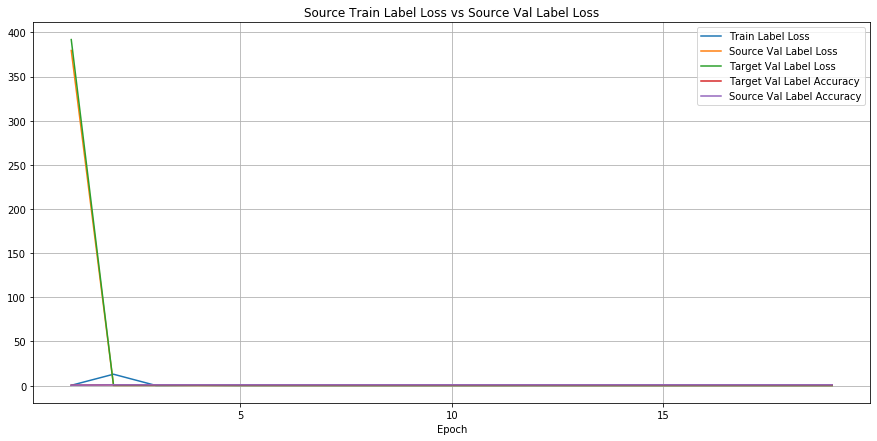

In [25]:
ax = get_loss_curve(experiment)
plt.show()

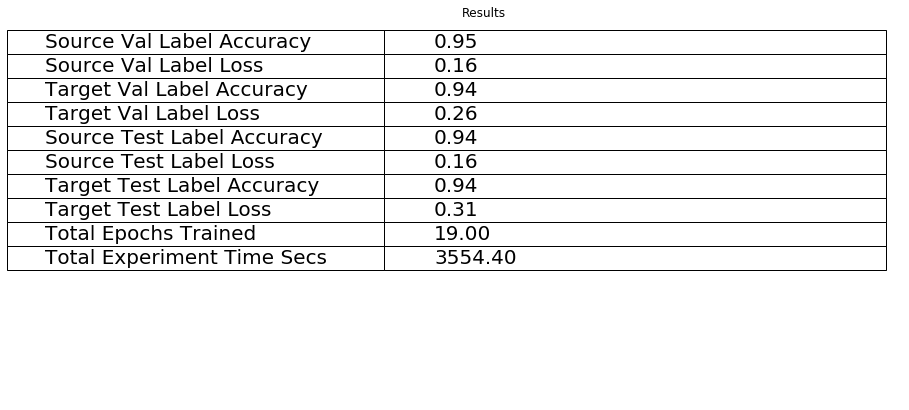

In [26]:
get_results_table(experiment)

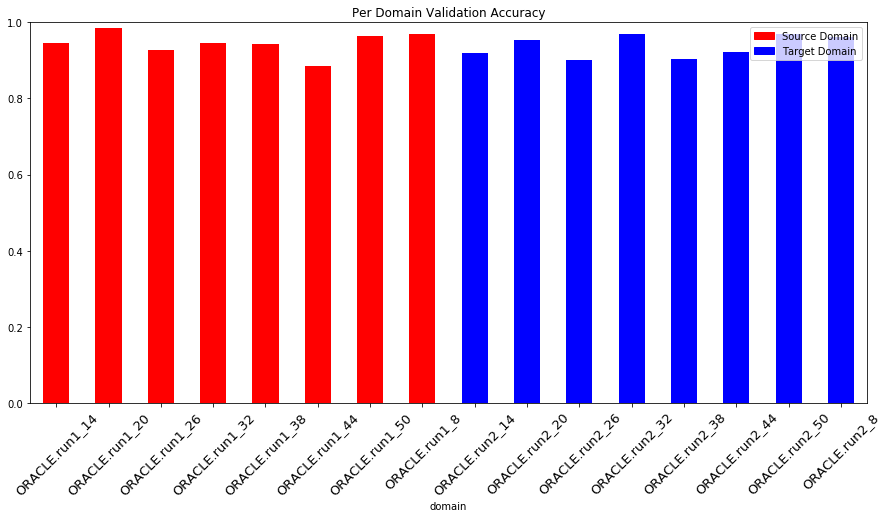

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9446614583333334 Target Test Label Accuracy: 0.9380208333333333
Source Val Label Accuracy: 0.9462239583333333 Target Val Label Accuracy: 0.9369791666666667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1_oracle.run1-oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480